<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/Class_activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
import opendatasets  as od

In [2]:
# Install a specific version of torch_snippets (version 0.553)
!pip install -U torch_snippets==0.553
import os
from torch_snippets import *

In [3]:
od.download('https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: korlilarryaddo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


100%|██████████| 675M/675M [00:05<00:00, 126MB/s] 


In [4]:
id2int = {'Parasitized':0,'Uninfected':1}

In [5]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [7]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [10]:
import shutil
shutil.move('/content/cell-images-for-detecting-malaria/cell_images/cell_images','/content/')

'/content/cell_images'

In [46]:
from  torch.utils.data import Dataset,DataLoader
import torch
class malariaImg(Dataset):
  def __init__(self,files,transforms):
    self.files = files
    self.transforms = transforms
    logger.info(len(self))
  def __len__(self):
    return len(self.files)
  def  __getitem__(self, index):
     fpath  = self.files[index]
     clss  =  fname(parent(fpath))
     img  = read(fpath,1)
     return img,clss

  def choose(self):
    return self[randint(len(self))]
  def collate_fn(self,batch):
    _imgs,classes =  list(zip(*batch))
    if  self.transforms:
      imgs = [self.transforms(img)[None] for img in  _imgs]

    classes = [ torch.tensor([id2int[cls]]) for cls  in classes]

    imgs,classes = [ torch.cat(i).to(device) for i in  [imgs,classes]]
    #imgs =  torch.stack(imgs).to(device) add the batch dim
    #classes = torch.cat(classes).to(device)
    return  imgs,classes,_imgs

In [16]:
device  = 'cuda'  if  torch.cuda.is_available()  else  'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files,val_files = train_test_split(all_files,random_state=1)

trn_ds = malariaImg(trn_files,transforms=trn_tfms)
val_ds = malariaImg(val_files,transforms=val_tfms)

trn_dl = DataLoader(trn_ds,32,shuffle=True,collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds,32,shuffle=False,collate_fn=val_ds.collate_fn)



[06/09/25 15:53:12] INFO     20668                                                                                                ]8;id=110412;file://<ipython-input-11-a1ae68a90e4b>:7\<ipython-input-11-a1ae68a90e4b>]8;;\:]8;id=202529;file://<ipython-input-11-a1ae68a90e4b>:7#__init__:7\__init__:7]8;;\

                    INFO     6890                                                                                                 ]8;id=681240;file://<ipython-input-11-a1ae68a90e4b>:7\<ipython-input-11-a1ae68a90e4b>]8;;\:]8;id=855578;file://<ipython-input-11-a1ae68a90e4b>:7#__init__:7\__init__:7]8;;\

In [18]:
img,l,_imgs =  next(iter(trn_dl))

In [27]:
img.shape,l.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
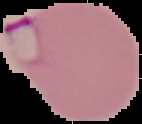

In [25]:
_imgs[0]

In [33]:
import torch.nn as nn
from sklearn.metrics import  accuracy_score
def convBlock(ni,no):
  return nn.Sequential(
      nn.Dropout(0.2),
      nn.Conv2d(ni,no,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

class  MalariaClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.features =  nn.Sequential(
        convBlock(3, 64),
        convBlock(64, 64),
        convBlock(64, 128),
        convBlock(128, 256),
        convBlock(256, 512),
        convBlock(512, 64),
    )
    with torch.no_grad():
      dummy  =  torch.rand(1,3,128,128)
      flattened = self.features(dummy)
      flattened = flattened.view(1,-1).size(1)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flattened,256),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(256,len(id2int))
    )

    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self,x):
    return self.classifier(self.features(x))
  def  compute_metrics(self,preds,targets):
    loss = self.loss_fn(preds,targets)
    preds =  torch.argmax(preds,dim=1)
    acc  = accuracy_score(preds.detach().cpu().numpy(),targets.cpu().numpy())
    return loss,acc

In [35]:
from torch.optim import  Adam
model =  MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer =  Adam(model.parameters(),lr=1e-3)

In [44]:

def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc

In [42]:
from torch_snippets.torch_loader import Report


In [45]:
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  val_acc: 0.949  val_loss: 0.159  trn_acc: 0.901  trn_loss: 0.255  (142.01s - 142.01s remaining)
EPOCH: 2.000  val_acc: 0.949  val_loss: 0.177  trn_acc: 0.946  trn_loss: 0.171  (278.39s - 0.00s remaining)


In [55]:
im2fmap = nn.Sequential(*(list(model.features[:5].children()) + list(model.features[5][:2].children())))


In [61]:
def img2gradCAM(x):
  model.eval()
  logits  = model(x)
  heatmaps = []
  activations = im2fmap(x)
  print(activations.shape)
  pred = torch.argmax(logits,dim=1)
  model.zero_grad()
  logits[0,pred].backward(retain_graph=True)
  pooled_grads = model.features[-6][1].weight.grad.data.mean((1,2,3))
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_grads[i]
  # take the mean of all weighted activation maps
  # (that has been weighted by avg. grad at each fmap)
  heatmap =torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, 'Uninfected' if pred.item() else 'Parasitized'


In [62]:
import  cv2
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


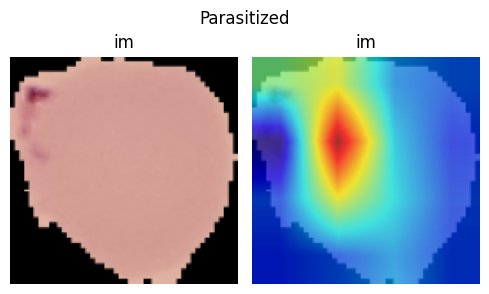

torch.Size([1, 64, 4, 4])


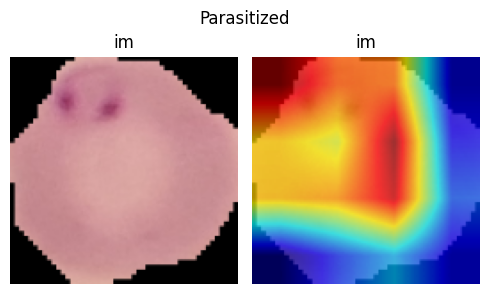

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


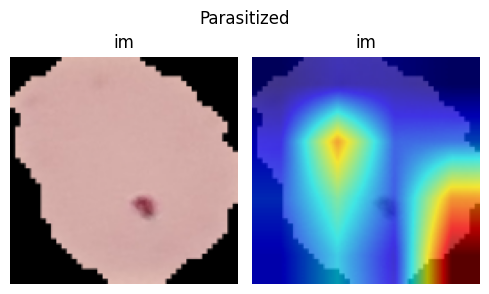

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


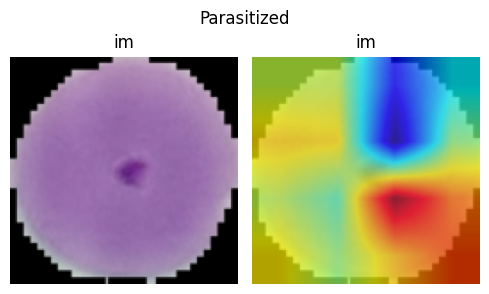

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


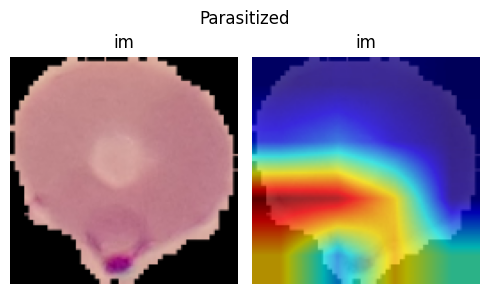

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


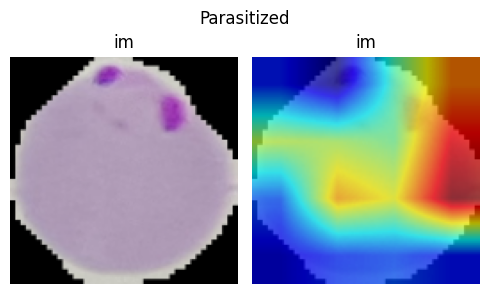

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


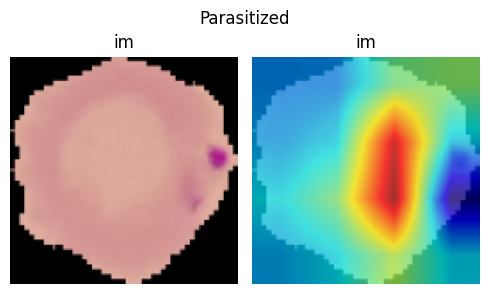

torch.Size([1, 64, 4, 4])


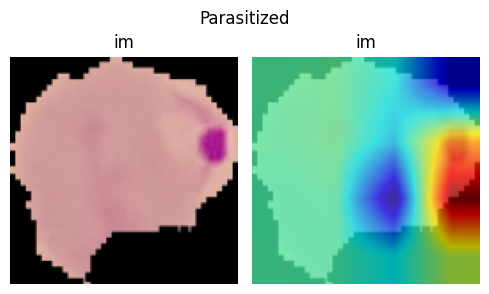

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


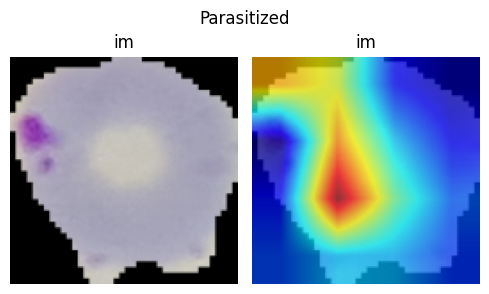

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


In [63]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = img2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)